In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix

from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Concatenate, Input

from src.inference import inference

download tensorflow data from below link in data_tf folder

https://public.roboflow.com/object-detection/american-sign-language-letters/1

## Restructure Data Path

In [12]:
from src.restructure_ds import restructure_dataset

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
dataset_dir = 'data_tf/train'
output_dir = 'data_tf/train'

restructure_dataset(dataset_dir, output_dir)

In [5]:
dataset_dir = 'data_tf/test'
output_dir = 'data_tf/test'

restructure_dataset(dataset_dir, output_dir)

In [6]:
dataset_dir = 'data_tf/valid'
output_dir = 'data_tf/valid'

restructure_dataset(dataset_dir, output_dir)

## Prepare data for training

In [2]:
train_dir = 'data_tf/train' 
test_dir = 'data_tf/test'
val_dir = 'data_tf/valid'

In [3]:
def preprocessing(root_dir):
    annotations_file = os.path.join(root_dir, '_annotations.csv')
    # Load annotations
    annotations = pd.read_csv(annotations_file)

    images = []
    bbox = []
    labels = []
    # Create a mapping of class labels to integers
    class_mapping = {class_name: i for i, class_name in enumerate(annotations['class'].unique())}

    for index, row in annotations.iterrows():
        image_path = os.path.join(root_dir, row['class'], row['filename'])
        image = Image.open(image_path)
        original_width, original_height = image.size
        image = image.resize((128, 128))  # resize the imag
        image = np.array(image) / 255.0
        images.append(image)
            
        # Normalize bounding box coordinates to be relative to image size
        bbox.append([(row['xmin'] / original_width) * 128, (row['ymin'] / original_height) * 128, 
                    (row['xmax'] / original_width) * 128, (row['ymax'] / original_height) * 128])
            

        labels.append(class_mapping[row['class']])  # add the class index to labels

    # Convert the lists to numpy arrays
    images = np.array(images)
    bbox = np.array(bbox)
    labels = np.array(labels)
    return images, bbox, labels

images, bbox, labels = preprocessing(train_dir)
test_images, test_bbox, test_labels = preprocessing(test_dir)
val_images, val_bbox, val_labels = preprocessing(val_dir)

In [4]:
grid_size = 16 # 128 / mask_size

In [5]:
def make_tensor(X, y, labels, bbox):
    # pickup random index
    idx = np.random.randint(len(X))

    # class of digit
    kls = labels[idx]
    
    # bbox of index
    bb = bbox[idx]
    
    bb_grid = [coord / 16 for coord in bb] 

   # the cell that the object belongs to
    cx, cy = int(bb_grid[0]), int(bb_grid[1])

    # Store class and bounding box information
    y[idx, cy, cx, 0] = 1.0  # objectness score
    y[idx, cy, cx, 1:5] = bb_grid  # bounding box
    y[idx, cy, cx, 5 + kls] = 1.0  # class score

def make_data(images, labels, bbox, size=64):
    X = np.zeros((size, 128, 128, 3), dtype=np.float32)
    y = np.zeros((size, 8, 8, 31), dtype=np.float32)  # adjusted the second dimension
    for i in range(size):
        X[i] = images[i]
        make_tensor(X, y, labels, bbox)
        
    X = np.clip(X, 0.0, 1.0)
    return X, y

X, y = make_data(images, labels, bbox, len(images))
test_X, test_y = make_data(test_images, test_labels, test_bbox, len(test_images))
val_X, val_y = make_data(test_images, test_labels, test_bbox, len(test_images))

## Define Model Architecture

In [6]:
num_classes = len(np.unique(labels))

x = x_input = Input(shape=(128, 128, 3))

x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
    
x_prob = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x)
x_boxes = Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x)
x_cls = Conv2D(26, kernel_size=3, padding='same', activation='sigmoid', name='x_cls')(x)

gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate
x_cls = x_cls * gate

x = Concatenate()([x_prob, x_boxes, x_cls])

model = Model(x_input, x)
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['batch_normalization[0][0

## Define Loss Functions

In [7]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]
idx_cls = list(range(5,31))

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
model.compile(loss=loss_func, optimizer=opt)

## Train model

In [11]:
history = model.fit(X,y,batch_size=32,epochs=100,shuffle=True, validation_data=(val_X, val_y))

Epoch 1/100
48/48 [==============================] - 18s 167ms/step - loss: 927.6306 - val_loss: 310.6463
Epoch 2/100
48/48 [==============================] - 6s 126ms/step - loss: 254.2705 - val_loss: 310.6463
Epoch 3/100
48/48 [==============================] - 6s 127ms/step - loss: 216.0922 - val_loss: 310.6490
Epoch 4/100
48/48 [==============================] - 6s 128ms/step - loss: 180.5853 - val_loss: 274.5765
Epoch 5/100
48/48 [==============================] - 6s 130ms/step - loss: 158.7195 - val_loss: 196.9645
Epoch 6/100
48/48 [==============================] - 6s 128ms/step - loss: 148.4728 - val_loss: 156.8831
Epoch 7/100
48/48 [==============================] - 6s 129ms/step - loss: 135.4684 - val_loss: 129.3763
Epoch 8/100
48/48 [==============================] - 6s 129ms/step - loss: 128.3984 - val_loss: 126.9103
Epoch 9/100
48/48 [==============================] - 6s 130ms/step - loss: 122.7566 - val_loss: 110.9370
Epoch 10/100
48/48 [==============================] - 

## Plot graph

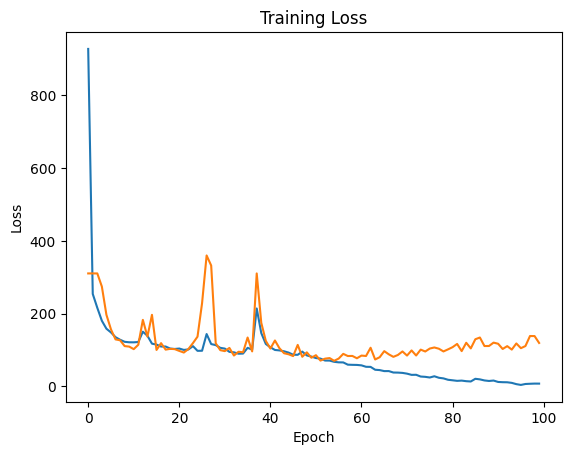

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Save model

In [13]:
model.save("models/scratch_yolo_with_val.h5")

## Load Model

In [26]:
model = load_model('models/scratch_yolo_with_val.h5', custom_objects={'loss_func': loss_func})

## Test performance on Validation dataset

In [11]:
y_pred_cls = []
y_test_cls = []

# Loop over all samples in the validation set
for idx in range(len(test_y)):

    # Get model's prediction for this sample
    predictions = model.predict(test_X[idx:idx+1])

    # Extract the predicted probabilities, bounding box coordinates, and classes
    predicted_prob = predictions[0, :, :, 0]
    predicted_boxes = predictions[0, :, :, 1:5]
    predicted_classes = predictions[0, :, :, 5:]

    # Extract true classes
    true_classes = test_y[idx, :, :, 5:]

    # Find indices of detected objects
    object_indices = np.where(predicted_prob > 0.5)

    # For each detected object, find predicted and true class
    for i in range(len(object_indices[0])):
        predicted_class = np.argmax(predicted_classes[object_indices[0][i], object_indices[1][i]])
        true_class = np.argmax(true_classes[object_indices[0][i], object_indices[1][i]])

        # Append predicted and true classes to the respective lists
        y_pred_cls.append(predicted_class)
        y_test_cls.append(true_class)

# Once you've accumulated all the predictions, compute the confusion matrix
y_pred_cls_flat = np.array(y_pred_cls).flatten()
y_test_cls_flat = np.array(y_test_cls).flatten()

cm = confusion_matrix(y_test_cls_flat, y_pred_cls_flat)


1/1 [==============================] - 0s 16ms/step


In [12]:
cm.shape

(20, 20)

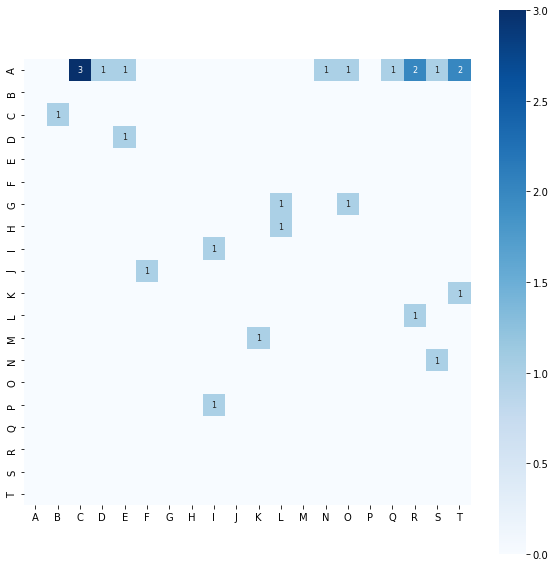

In [13]:
# Convert cm to str type
cm = cm.astype(str)

# Create an array same size as cm with True for non-zero and False for zero
mask = cm != '0'

# Create an annotation array that is the same as 'cm' where your condition is met and blank elsewhere
annot = np.where(mask, cm, np.full_like(cm, ''))

# Define the labels
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
labels = labels[:cm.shape[0]]  # Trim the labels to match the number of unique classes in the confusion matrix

plt.figure(figsize=(10, 10))

# Create the heatmap
sns.heatmap(
    cm.astype(int),  # Convert back to int for plotting
    annot=annot,
    annot_kws={'size': 8},
    cmap='Blues',
    fmt='',  # Set format to string
    square=True,
    vmin=0.0,
    xticklabels=labels,  # Set the labels directly in the heatmap function
    yticklabels=labels
).set_facecolor((1, 1, 1))

plt.show()




## Make individual inference

1/1 [==============================] - 0s 57ms/step


(2, <matplotlib.image.AxesImage at 0x152e8dfd0>)

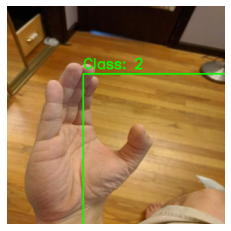

In [28]:
inference(model, "data_tf/test/C/C19_jpg.rf.577ce02a223c65e89dc4a4eacd130040.jpg")

1/1 [==============================] - 0s 48ms/step


(7, <matplotlib.image.AxesImage at 0x1534ff580>)

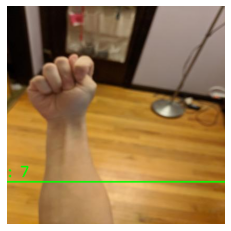

In [31]:
inference(model, "data_tf/test/T/T24_jpg.rf.068e7b2424eac996c86bb6d9c38e083d.jpg")

1/1 [==============================] - 0s 56ms/step


(5, <matplotlib.image.AxesImage at 0x15354f940>)

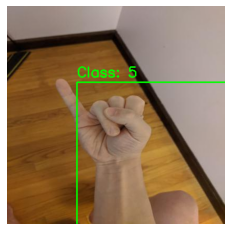

In [32]:
inference(model, "data_tf/test/I/I17_jpg.rf.8f1ed619e93147f7f9754a4eddbb90de.jpg")